# AI Kit

This jupyter notebook series constitutes a miscellaneous collection of code-snippeds for generic tasks in ML/DL-projects. The purpose is to speed up and ease model development by providing content for copying / pasting / and further customization. Each section constitutes a separat jupyter notebook.

#### A - BASICS
1. **Data Preprocessing** - Imputation, Normalization
2. **Oulier Detection** - Univariate Z-Score, Isolation Forest, Elliptic Envelope, DBSCAN
3. **Dimensionality Reduction** - PCA, tSNE

#### B - MACHINE LEARNING (SkLearn)
1. **Model Selection** - Benchmarking Algorithms with default Hyperparameters
2. **Hyperparamter Tuning** - Random Search, Learning Curves

#### C - DEEP LEARNING (Keras)
1. **Neural Nets** - Keras Sequential Model
2. **CNNs** - from Scratch, Transferlearning
3. **RNNs** - from Scratch, Transferlearning
4. **Complex Model Graphs** - Functional Keras API

## Notebook B2 - Hyperparameter Tuning

* [**Preprocess Data**](#pd)
* [**SvmRBF**](#svm)
* [**Gradient Boosting**](#gb)

### Preprocess Data <a name="pd"></a>

For details refer to previous notebook 1_DataPreprocessing

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

titanic = sns.load_dataset('titanic')

# Directly remove features 'alive' and 'embark_town' which duplicate 'survived' and 'embark'
titanic = titanic.drop(columns=['embark_town', 'alive'])

# Drop feature 'deck' with too many NAs
titanic = titanic.drop(columns='deck')

# Impute age with average
titanic.loc[titanic.age.isna(), 'age'] = titanic.age.mean()

# Impute embarked with most frequent
titanic.embarked.value_counts()

# One hot encode categorical features
titanic_categorical = titanic.loc[:, (titanic.dtypes=='object') | (titanic.dtypes=='category')]
titanic = titanic.drop(columns=titanic_categorical.columns)
titanic = titanic.join(pd.get_dummies(titanic_categorical, drop_first=True))

# Convert everything to float32
titanic = titanic.astype('float32')
titanic.head()

# Lognormalize 'price'
titanic['fare'] = np.log(titanic.fare+1)

# Normalize non-categorical features
titanic.loc[:, 'pclass':'fare'] = (titanic.loc[:, 'pclass':'fare'] - titanic.loc[:, 'pclass':'fare'].mean()) /\
                                                                     titanic.loc[:, 'pclass':'fare'].std()

### SvmRBF <a name="svm"></a>

The highest accuracy-levels for survival (yes/no) by non-tuned algorithms (with default hyperparameters) were attained by SvmRBF and GradientBoost (see last notebook 4_ModelSelection). Hence, we restrict our attaintion on these two algorithms and try to attain higher levels of accuracy by finding more optimized hyperparamter values.

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# train_test_split() deploys shuffle=True per default
X_train, X_test, y_train, y_test = \
        train_test_split(titanic.drop('survived', axis=1), titanic.survived, test_size=0.3, random_state=42)

# Specify hyperparamter grid as dictionary ('hyperparameter name': values)
param_grid = {'C':np.arange(.5,1.5,.1), 'gamma':np.arange(.01,.1,.01)}

# Set up gridsearch with 5-fold crossvalidation (cv=5)
svr = RandomizedSearchCV(SVC(kernel='rbf', random_state=42), param_grid, scoring='accuracy', cv=5, n_iter=50)

# Conduct gridsearch
svr.fit(X_train, y_train)

# Accuracy on test data for best fit
accuracy_score(svr.predict(X_test), y_test)

0.8208955223880597

In [53]:
svr.best_estimator_

SVC(C=1.1999999999999997, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

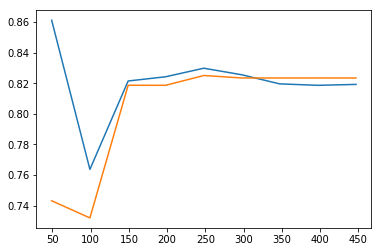

In [54]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(svr.best_estimator_, \
                                                      X_train, y_train, cv=5, n_jobs=None, train_sizes=np.arange(.1,1,.1))

ax = sns.lineplot(x=train_sizes, y=np.mean(train_scores, axis=1))
ax = sns.lineplot(x=train_sizes, y=np.mean(validation_scores, axis=1))

### Gradient Boosting <a name="gb"></a>

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# Specify hyperparamter grid as dictionary ('hyperparameter name': values)
param_grid = {'learning_rate':np.arange(.05,.15,.01), 'n_estimators':np.arange(100,600,100), 'max_depth':np.arange(2,5,1)}

# Set up gridsearch with 5-fold crossvalidation (cv=5)
gb = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='accuracy', cv=5, n_iter=50)

# Conduct gridsearch
gb.fit(X_train, y_train)

# Accuracy on test data for best fit
accuracy_score(gb.predict(X_test), y_test)

0.8097014925373134

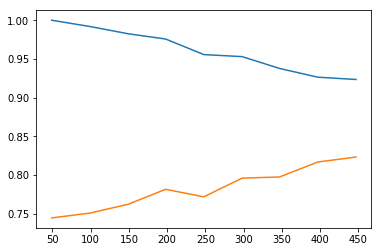

In [55]:
train_sizes, train_scores, validation_scores = learning_curve(gb.best_estimator_, \
                                                      X_train, y_train, cv=5, n_jobs=None, train_sizes=np.arange(.1,1,.1))

ax = sns.lineplot(x=train_sizes, y=np.mean(train_scores, axis=1))
ax = sns.lineplot(x=train_sizes, y=np.mean(validation_scores, axis=1))